# Markov Chain Monte Carlo Methods

## 1. Introduction
In the previous workbook, we went over various techniques for using Monte Carlo methods to evaluate functions, their integrals, and their gradients. In general, these techniques relied on evaluating an expectation in the form of an integral, in order to estimate the quantity of interest. In this workbook we'll go over a different class of methods that are used for sampling from an otherwise inaccessible *distribution* -- that is, we will no longer get a point estimate, but rather a range of possibilities. Furthermore, these methods will let us sample from these distributions, no matter what their shape!

These methods are known as Markov Chain Monte Carlo, and work by constructing a Markov chain that has the distribution of interest as its stationary distribution. To introduce the concepts, this workbook will cover:

1. Motivations -- why do want to estimate these distributions in the first place? This section will cover the basics of Bayes' theorem, and normalization constants.
2. The basics of rejection sampling. MCMC methods rely on proposed jumps in the parameter space, and accepts or rejects these jumps probabilistically. We will illustrate the basics of rejection sampling with a few simple examples.
3. Slice sampling, as a demonstration of an algorithm that "walks" through the sampling space under some function. 
4. The Metropolis algorithm and Gibbs sampling, including a basic rundown of the accept-reject criteria, and some intuition as to why it works.
5. A worked example where we obtain some data, and do regression to find the parameter $\theta$ that best fits the data. We show the distinction between MCMC, where we obtain a distribution over a range of $\theta$s, maximum likelihood estimation, where we fit to the mean of the likelihood, and *maximum a priori*, where we find the mean of posterior distribution. To show that we are indeed sampling from the posterior, we compare the sampled distribution to the analytical solution.

For each of these sections, we will see examples of working code that cover the ideas covered in the text, so that you can understand not only the maths, but also its implementation to solve toy problems. As with the previous workbook, each section is self-contained so that you can jump ahead and run the sections you're interested in.

### 1.1 Motivations: Bayes' Theorem and Normalization Constants
In order for a function to be a probability distribution, it must assign some probability mass to an input $X$. Since the probability of an outcome can never be less than $0\%$, or greater than $100\%$, our distribution cannot assign probability less than a value of $0$, or more than a value of $1$ to an outcome. Secondly, the sum of all outcomes cannot exceed $100%$, meaning that our distribution needs to integrate to $1$ over its range.

With these criteria in mind, we can treat any function as a probability distribution by normalizing it:

$p(x) = \frac{f(x)}{\int_{x}f(x)dx}$

That is, using a normalization constant (typically denoted as $Z$) we can ensure that our model integrates to 1 over its domain, letting us treat values of the function as a probability density. In code below:

In [26]:
import numpy as np

f = lambda x : x ** 2
g = lambda a, b : (1/3) * (b ** 3 - a ** 3)

samples = 1000
a, b = 0, 2
x = np.random.uniform(a, b, samples)
f_x = f(x)
z = g(a, b)
z_ = np.mean(f_x) * (b - a)

print("Analytic constant: ", z)
print("Estimated constant: ", z_)
print("Integral with analytic constant: ", np.mean(f_x / z) * (b - a))
print("Integral with estimated constant: ", np.mean(f_x / z_) * (b - a))

Analytic constant:  2.6666666666666665
Estimated constant:  2.70074392457
Integral with analytic constant:  1.01277897172
Integral with estimated constant:  1.0


In general, computing the normalization constant is difficult or impossible for many problems of interest. This is particularly the case in Bayesian methods, in which we want to compute the posterior probability of some parameter:

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

For those unfamiliar with Bayes' theorem, the above formula tells us that for a joint distribution $P(A,B)$, we can factorize it as $P(A,B) = P(A|B)P(B) = P(B|A)P(A)$. In the case where $A$ and $B$ are independent, then this just becomes $P(A,B) = P(A)P(B)$. Rearranging $P(A|B)P(B) = P(B|A)P(A)$ gives us the above expression.

The density $P(A|B)$ is known as the posterior, and represents our belief in some model after considering the evidence for it, and our initial belief (some bias). $P(B|A)$ is called the likelihood, and $P(A)$ is our prior belief in the parameter $A$ that we are trying to estimate (for example, we may have some initial data points that suggests how likely A is). As an intuitive example, imagine we are trying to fit a dataset $\mathcal{D}$ using some parameter vector $\theta$. In this case, our formula is:

$P(\theta|\mathcal{D}) = \frac{P(\mathcal{D}|\theta)P(\theta)}{P(\mathcal{D})}$

The quantity $P(\mathcal{D}|\theta)$ is our likelihood, and typically represents the probability that we are trying to maximize in MLE. That is, it's our mean squared-error loss, or some form of log probability loss that we are trying to minimize (which corresponds to maximizing the likelihood). Next, $P(\theta)$ represents some initial belief about our parameters $\theta$ -- for example, we might assume $\theta \sim \mathcal{N}(0, \mathbb{I})$, which would correspond to favouring models that have parameters close to zero (i.e. they are "simpler" -- we can set parameter weights for unnecessary parameters to be $0$, which removes them). Finally, $P(\mathcal{D})$ represents the probability of the data, which highlights a major problem that many Bayesian methods encounter. How do you even begin to ask the question "how probable is the data"?

We can deal with this by integrating over $\theta$, giving us an expression of the form:

$P(\theta|\mathcal{D}) = \frac{P(\mathcal{D}|\theta)P(\theta)}{\int_{\theta}P(\mathcal{D}, \theta)d\theta}$

But this integral is intractable for most interesting problems.

So how do we solve this?

Well, there are a few ways. One way is to notice that $P(\mathcal{D})$ is just a normalization constant for the distribution $P(A,B)$. This means that we can reframe our problem as being:

$P(\theta|\mathcal{D}) = \frac{P(\mathcal{D}|\theta)P(\theta)}{Z}$

For some normalizing constant $Z$. As a result, $P(\theta|\mathcal{D}) \propto P(\mathcal{D},\theta)$

This means that in many cases where we want to compute the posterior, we will instead have to find some way of computing $P(\mathcal{D},\theta)$, which gives us the mean of the posterior up to a normalization constant.

However, it bears mentioning here that the posterior is a *distribution*, so there are, in fact, a range of values that our parameter $\theta$ can take. It's typically quite difficult to sample from this distribution, and so the more common application of Bayes' theorem is finding the *Maximum A Posteriori* estimate. That is, we find the mean of our posterior distribution, typically using some form of optimization, which corresponds to finding the MAP estimate. This amounts to using regularization when doing regression on a series of datapoints -- in statistics they might call this Ridge or Lasso regularization depending on the prior, and in machine learning, we'd call this $L1$ or $L1$ regularization, depending on the weight penalty that is used.

But what if we want to know the full posterior distribution? It's intuitive that knowing how confident we are about a parameter or value is inherently useful. Well that, my friends, is what this notebook is all about. I hope you brought your loose pants, because we're about to take a deep dive into Markov Chain Monte Carlo methods, where we use clever maths to be able to sample from and estimate what are otherwise intractable distributions.


## 2. Markov Chain Monte Carlo

The sampler is the main ingredient in Markov Chain Monte Carlo methods, and so it's important we give it a proper treatment here. The general idea is that we want to be able to sample from some distribution $p(x)$ without having direct access to $p(x)$ -- rather, we have access to an un-normalized version of $p(x)$ that we denote $f(x)$. To get around this, our goal is to create a known distribution $q(x)$ that we choose, and then figure out a way to use it to sample from $p(x)$. The first method we'll cover here is Rejection Sampling, and we'll use this as a bridge to MCMC by looking at Slice Sampling and the Metropolis algorithm.

### 2.1 Rejection Sampling
The idea of rejection sampling is simple: say we want to draw from some distribution $p(x)$, but we don't have access to that distribution. Rather, we can sample from a proposal distribution $q(x)$ instead, and accept or reject it based on some acceptance criteria such that $f(x) \in \mathcal{A}$ for some set $\mathcal{A}$. This requires 1) that our proposal distribution $q(x)$ envelopes the distribution $p(x)$ (see the below Figure), and 2) that we have access to some kind of acceptance / rejection criteria that tell us if $f(x) \in \mathcal{A}$ or not.

As an example, say we want to sample from a circular distribution with fixed radius $R$. An effective way to do this is rejection sampling from a square (sampling $x \sim \mathcal{U}(-R, R)$ and $y \sim \mathcal{U}(-R, R)$), and then rejecting the sample if it falls outside of the radius:

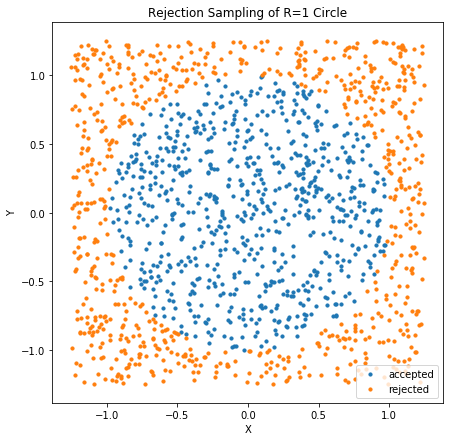

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# rejection sampling algorithm
samples = 1500
rad = 1
a, b = -1.25, 1.25
xs, ys = [], []
xs_r, ys_r = [], []
for i in range(samples):
    xy = np.random.uniform(a, b, (2,))
    mag = np.linalg.norm(xy)
    if mag < rad:
        xs.append(xy[0])
        ys.append(xy[1])
    else:
        xs_r.append(xy[0])
        ys_r.append(xy[1])

# plot everything
plt.figure(figsize=(7,7))
plt.scatter(xs, ys, s=10)
plt.scatter(xs_r, ys_r, s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Rejection Sampling of R=" + str(rad) + " Circle")
plt.legend(["accepted", "rejected"])
plt.show()

This is a pretty simple and intuitive demonstration of the concept, and nicely illustrates the concept of having an enveloping function. A square region of side length $L \geq 2R$ fully envelopes the area that we're interested in, and we know that all points within the circular region can have a maximum magnitude of $R$ as measured from the origin, giving us an easy acceptance / rejection criteria.

As a procedure, rejection sampling uses the following steps:

1. Sample $X\sim \mathcal{U}(a, b)$.
2. Evaluate $f(X)$.
3. If $f(X) \in \mathcal{A}$, accept $X$, else reject $X$.
4. Repeat steps 1 to 3.

This method can be advantageous in certain cases -- for example, imagine that we wanted to integrate to find the area of a circle. If we used a standard method of integrating to take the expectation of $f(x)$, we would need to come up with an expression for the circle, and integrate over both dimensions. Using rejection sampling, the process is far simpler, since we can just take the ratio between the number of points that fell within the circle, and the total number of samples taken:

In [126]:
import numpy as np
from math import pi

samples = 50000
rad = 9
a, b = -15, 15

data = []
for i in range(samples):
    xy = np.random.uniform(a, b, (2,))
    mag = np.linalg.norm(xy)
    if mag < rad:
        data.append(1)
print("Estimated integral: ", ((b - a) ** 2) * (sum(data) / samples)) 
print("Analytical area: ", pi * rad**2)

Estimated integral:  255.222
Analytical area:  254.46900494077323




### 2.2 Slice Sampling
The idea of slice sampling is simple:

1. Choose an initial point x.
2. Draw a sample from $y \sim \mathcal{U}(0, f(x))$.
3. Draw a horizontal line to find the left and right bounds of $f(x) = y$.
4. Sample $x \sim \mathcal{U}(x_{min}, x_{max})$
5. Repeat steps 2 to 4.

Essentially, we can think of the state $x$ as the position of a particle that moves around under $f(x)$. Due to the way in which new states are proposed, our particle spends proportionately more time in areas with high probability mass than those with low probability mass.

To illustrate the principle, we'll sample from the function $f(x) = x^2 + 9$ in the interval $[-3, 3]$ so that we can guarantee $f(x) \geq 0$. We want to be able to map some $y = f(x)$ to an argument $x$ in order to find the upper and lower bounds, so we'll make our lives easier by inverting the function to find $f^{-1}(y) = x = \pm\sqrt{9 - y}$. In a typical application we likely wouldn't be able to do this, and would have to find the upper and lower bounds using a search. In this case, it inverting the function suffices to demonstrate the principle, and makes things a bit simpler!

Our algorithm now becomes:

1. Choose x0.
2. Draw a sample from $y \sim \mathcal{U}(0, f(x))$.
3. Find $x_{min}, x_{max} = \pm f^{-1}(y)$
4. Sample $x \sim \mathcal{U}(x_{min}, x_{max})$
5. Repeat steps 2 to 4.

In code:

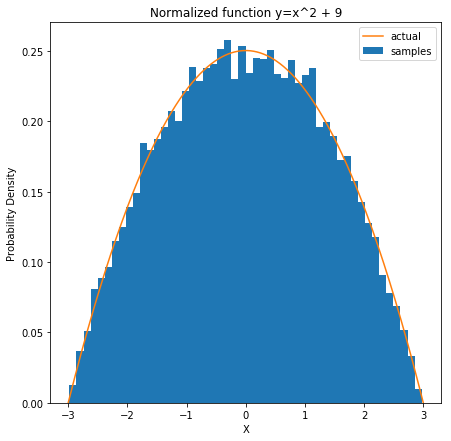

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

f = lambda x : -x**2 + 9

# inverse function to get x_min, x_max
def g(y):
    z = sqrt(9 - y) 
    return -z, z

# run sampling algorithm
samples = 25000
a, b = -3, 3
x = np.random.uniform(a, b)
data = []
for i in range(samples):
    y = np.random.uniform(0, f(x))
    x_min, x_max = g(y)
    x = np.random.uniform(x_min, x_max)
    data.append(x)

# calculate values of interest
xs = np.linspace(-3, 3, 1000)
ys = f(xs)
normed = ys/((b - a) * np.mean(ys))

# plot everything
plt.figure(figsize=(7,7))
plt.hist(data, bins=50, density=True)
plt.plot(xs, normed)
plt.title("Normalized function y=x^2 + 9")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.legend(["actual", "samples"])
plt.show()

As we can see, our estimate of the normalized distribution is pretty close to the real thing. One of the benefits of this type of sampling is that there are no rejections. The downside is that it may involve additional searches or function inversion to find the upper and lower bounds of our function at $y = f(x)$.

### 2.3 The Metropolis Algorithm
The Metropolis algorithm is considered one of the jewels of computer science, and provides the basis for many modern MCMC methods (including Hamiltonian Monte Carlo). Whereas slice sampling only ever samples from the area under the curve of $f(x)$, the Metropolis Algorithm is more akin to a particle doing a random walk through a search space. This random walk is known as a Markov process, and an important property of Markov processes is that they converge to a stationary distribution $\pi(x)$ if two conditions are met:

1. The stationary distribution exists; and,
2. The stationary distribution is unique.

In general, the goal is to have a particle that probabilistically moves through a space according to some transition probability $P(x_{k+1}|x_k)$, such that it explores the whole space given enough time (ergodicity) and that in so doing it will occupy states according to the stationary distribution $\pi(x)$, where we set $\pi(x) = P(x)$, where $P(x)$ is the distribution that we want to sample from.

So how is this done? The key is a trick called *detailed balance*, which is the requirement that:

$P(x_{k+t}|x_k)P(x_k) = P(x_{k}|x_{k+1})P(x_{k+1})$

Which, provided the process is ergodic, ensures that our Markov process has a stationary distribution. The transition probability is broken up into:

$P(x_{k+t}|x_k) = A(x_{k+1},x_k)g(x_{k+1}|x_k)$

Where $g(x_{k+1}|x_k)$ is a proposal distribution (that we choose) that proposes new candidates for $x$ given some current state (for example, $x_{k+1} = x_k + h\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbb{I})$), and $A(x_{k+1},x_k)$ is the probability of accepting the proposal. Using our detailed balance criterion:

$A(x_{k+1},x_k)g(x_{k+1}|x_k)P(x_k) = A(x_{k},x_{k+1})g(x_k|x_{k+1})P(x_{k+1})$

Rearranging this:

$\frac{A(x_{k+1},x_k)}{A(x_{k},x_{k+1})} = \frac{g(x_k|x_{k+1})P(x_{k+1})}{g(x_{k+1}|x_k)P(x_k)}$

If we want $A(x_{k+1},x_k)$ to be a valid distribution, its range should be $[0, 1]$. A convenient way to meet this requirement is to take the minimum:

$P = \min \left(1, \frac{g(x_k|x_{k+1})P(x_{k+1})}{g(x_{k+1}|x_k)P(x_k)}\right)$

and to accept transitions with probability $P$. This is typically done by sampling some value $u \sim \mathcal{U}(0,1)$, and then moving to $x_{k+1}$ if $u \lt P$. The intuition here is that if $P > 1$, we want to move to the new location with probability $1$, but if $P < 1$, we move there in proportion to the ratio. As it turns out, this choice both preserves the detailed balance criterion, and is optimal.

Thinking about the intuition here, if we come up with some way of making a proposal for $x_{new}$, we can find out if it's more or less likely under the distribution $f(x_{new})$ than our current $x$ is. If we initialized a particle at some point $x_0$, and then randomly proposed new $x$s in its region, we could walk the particle to the area with the highest probability density by always always accepting the proposal if the ratio is greater than 1.

But what if we want to walk through the whole distribution, and spend a proportional amount of time in each state? That is, we want the particle to spend most of its time in high probability regions, but we also want it to spend time in lower probability regions proportional to their density? in these cases, we accept the proposal randomly in proportion to the ratio.

In practice, if we choose a symmetric proposal distribution for $g(x_{k+1}|x_k)$, then we can cancel these two terms, leaving only $\frac{P(x_{k+1})}{P(x_k)} = \frac{f(x_{k+1})}{f(x_k)}$. To demonstrate the algorithm in a few simple cases:

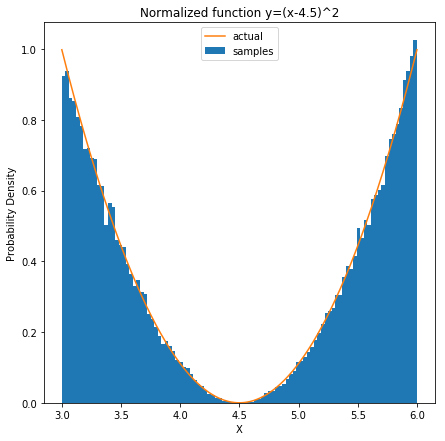

In [144]:
import numpy as np
import matplotlib.pyplot as plt

f = lambda x : (x - 4.5) ** 2
a, b = 3, 6

# run our sampling algorithm
data = []
iters = 100000
x = np.random.uniform(a, b)
for i in range(iters):
    x_new = np.random.uniform(a, b)
    ratio = np.clip(f(x_new)/f(x), 0, 1)
    k = np.random.uniform(0, 1)
    if k < ratio:
        x = x_new
    data.append(x)

# calculate values of interest
x = np.linspace(a, b, 1000)
vals = f(x)  / (np.mean(f(x)) * (b - a))

# plot everything
plt.figure(figsize=(7,7))
plt.hist(data, bins=100, density=True)
plt.plot(x, vals)
plt.title("Normalized function y=(x-4.5)^2")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.legend(["actual", "samples"])
plt.show()

In this case, we used a uniform distribution to propose a new value for $x$, so that our integration was bounded over the desired interval. More typically, a normal distribution is used, and the proposal is sampled using $x_{proposal} \sim \mathcal{N}(x_{current}, \sigma)$. One way to think of this sampling strategy is that it's a random walk through the parameter space. We can think of our $x$ variable as being a particle that travels through this space with a random jump at each step; over time, it will spend more time in areas with a higher associated probability mass. The catch is that this jump size needs to be tuned, since we may run into situations where it either doesn't explore the space efficiently, or it doesn't have the energy to jump between multiple local maxima in the case of multimodal functions.

A quick demonstration of the Metropolis algorithm using a normally distributed jump step is given below. Play around with the sigma value to see what effect it has on the estimate of the posterior. What happens if it's too small? Too big?

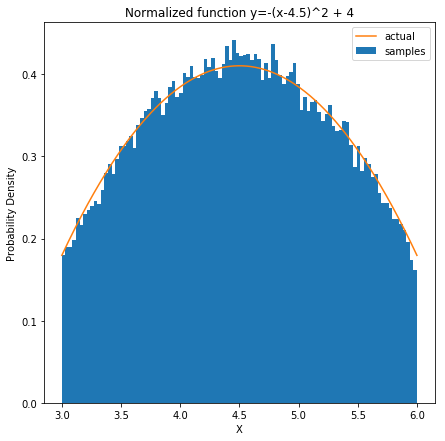

In [229]:
import numpy as np
import matplotlib.pyplot as plt

f = lambda x : -(x - 4.5) ** 2 + 4

# sampling routine, to keep our samples bounded to the interval
def sample(x):
    accept = False
    while not accept:
        x_new = np.random.normal(x, sigma)
        if a <= x_new and x_new <= b:
            accept = True
    return x_new

# sampling parameters
sigma = 5
a, b = 3, 6

# run our sampling algorithm
data = []
iters = 100000
x = sample(np.random.uniform(a, b))
for i in range(iters):
    x_new = sample(x)
    ratio = np.clip(f(x_new)/f(x), 0, 1)
    k = np.random.uniform(0, 1)
    if k < ratio:
        x = x_new
    data.append(x)

# calculate values of interest
x = np.linspace(a, b, 1000)
vals = f(x)  / (np.mean(f(x)) * (b - a))

# plot everything
plt.figure(figsize=(7,7))
plt.hist(data, bins=100, density=True)
plt.plot(x, vals)
plt.title("Normalized function y=-(x-4.5)^2 + 4")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.legend(["actual", "samples"])
plt.show()

As we can see, we're able to sample from the target distribution, and the approximation is pretty good. One limitation of the algorithm is that there are no guarantees regarding how long it takes to converge. "Enough time" could mean the age of the universe for a sufficiently difficult problem.

### 2.4 Gibbs Sampling
Gibbs sampling is a special case of the Metropolis algorithm, and so we will only go through it briefly (though the example will be a bit more involved). The chief difference between the Metropolis Algorithm and Gibbs Sampling is that in Gibbs Sampling, we loop through all of our sampled variables in order, and sample a new proposal for one of the variables while holding the others constant. This naturally assumes that we have some form of multivariable function, which we didn't assume earlier with the Metropolis algorithm (though the metropolis algorithm also works for dimensionality greater than 1).

To demonstrate this idea, we will need to define a multivariate function, and then sample one the variables while holding the others constant. In code this amounts to a simple modification to our original Metropolis algorithm loop:

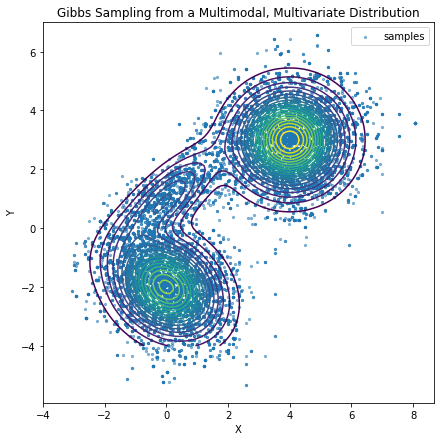

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# parameters for our multimodal distribution.
mu_1, mu_2, mu_3 = np.array([0, 1]), np.array([4, 3]), np.array([0, -2])
cov_1 = np.array([[1, 0.75],
                  [0.75, 1]])
cov_2 = np.array([[1, 0],
                  [0, 1]])
cov_3 = np.array([[1, -0.25],
                  [-0.25, 1]])

mvn_1 = stats.multivariate_normal(mean=mu_1, cov=cov_1)
mvn_2 = stats.multivariate_normal(mean=mu_2, cov=cov_2)
mvn_3 = stats.multivariate_normal(mean=mu_3, cov=cov_3)

w_1 = 0.1
w_2 = 0.5
w_3 = 0.4

z = 2

# un-normalized multimodal, multvariate function. This is a 2D Gaussian Mixture Model multiplied by
# some constant value Z.
def f(xy):
    pdf = w_1 * mvn_1.pdf(xy) + w_2 * mvn_2.pdf(xy) + w_3 * mvn_3.pdf(xy)
    return z * pdf

# sampling parameters
sigma = 5
a, b = -4, 7

# run our sampling routine
data = []
iters = 10000
x = np.random.uniform(a, b, (2,))
for i in range(iters):
    for j in range(2):
        x_new = x.copy()
        x_new[j] += np.random.normal(0, sigma)
        ratio = np.clip(f(x_new)/f(x), 0, 1)
        k = np.random.uniform(0, 1)
        if k < ratio:
            x = x_new
        data.append(x)

# calculate values of interest
data = np.vstack(data)
size = 100
xs = ys = np.linspace(a, b, size)
X, Y = np.meshgrid(xs, ys)
vals = np.array([[f(np.array([X[i,j], Y[i,j]])) for j in range(size)] for i in range(size)])

# plot everything
plt.figure(figsize=(7,7))
plt.scatter(data[:,0], data[:,1], s=5, alpha=0.5)
plt.contour(xs, ys, vals, 20)
plt.title("Gibbs Sampling from a Multimodal, Multivariate Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["samples"])
plt.show()

As we can see, we managed to sample even from this troublesome distribution -- visually, the samples correspond very well to the actual distribution shown by the contour plot.

### 2.5 Application: Bayesian Regression to a Dataset
So how can we use this idea to our advantage in order to fit a model? Well, let's say that we have some data such as the following:

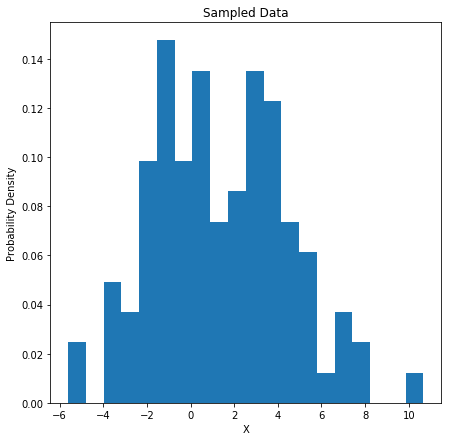

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, log, exp

f = lambda x, mu, sigma : 1/(sigma * sqrt(2 * pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# generate some dummy data
mu_star, sigma_star = 1.5, 3
data = np.random.normal(mu_star, sigma_star, (100,))

plt.figure(figsize=(7,7))
plt.hist(data, bins=20, density=True)
plt.title("Sampled Data")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.show()

Our goal is fit some model of the data that we can use to make predictions regarding unseen examples (i.e. examples that aren't in our dataset). In this case, we'll be fitting a parameterized model -- that is, defining a function as a set of parameters $\theta$ -- and finding the values of $\theta$ that best explain the data. To do this, we set the problem up so that our target distribution (i.e. the one we want to sample from, but don't quite know) is the posterior distribution of our regression problem over $\theta$ -- i.e. $P(\theta|\mathcal{D})$.

The first thing we need to do is select a model that we believe reflects the data. With no other information to go on, we might assume the generating distribution of the data is Gaussian, with parameters $\theta = \left[\mu, \sigma \right]$. We want to find the parameters $\theta$ that fit this model, but we have some initial beliefs over how $\theta$ is distributed. That is, we want to find a distribution of $\theta$s that best fits the data whilst taking our initial beliefs into account. From our earlier discussion on Bayes' theorem, we are finding:

$p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{P(\mathcal{D})}$

Where our normalizing constant is unknown. This sounds like a job for MCMC! To make our lives easier, our only parameter will be the mean. In principle, we could also find the standard deviation, but we would have to introduce additional restrictions to ensure that our proposal is positive. For this reason, we'll just keep it simple.

#### 2.5.1 Markov Chain Monte Carlo

Unknown mu* is 1.50; sigma* is 3.00
Known mu_data is 1.42; sigma_data is 3.04
Known mu_prior is 0.00; sigma_prior is 1.00
Analytic mu_posterior is 1.30; sigma_posterior is 0.29
Found mu: 1.30; sigma: 0.29


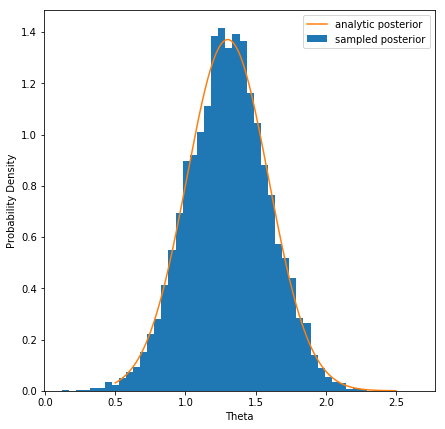

In [214]:
# sample mean and standard deviation, and our prior beliefs
mu_data, sigma_data = np.mean(data), np.std(data)
mu_prior, sigma_prior  = 0, 1

# calculating the analytical posterior using the data and prior, and assuming a Normal distribution
n = len(data)
var_posterior = (1 / sigma_prior ** 2 + n / sigma_data ** 2) ** -1
sigma_posterior = var_posterior ** 0.5
mu_posterior = var_posterior * (mu_prior / sigma_prior ** 2 + n * mu_data / sigma_data ** 2)

# print out the values of interest
print("Unknown mu* is {:.2f}; sigma* is {:.2f}".format(mu_star, sigma_star))
print("Known mu_data is {:.2f}; sigma_data is {:.2f}".format(mu_data, sigma_data))
print("Known mu_prior is {:.2f}; sigma_prior is {:.2f}".format(mu_prior, sigma_prior))
print("Analytic mu_posterior is {:.2f}; sigma_posterior is {:.2f}".format(mu_posterior, sigma_posterior))

# run our sampling algorithm
samples = []
iters = 100000
burn_in = 1000
x = np.random.uniform(-1, 1)
jump = 5
for i in range(int(burn_in + iters)):
    x_new = x + jump * np.random.normal()
    proposal = np.prod(f(data, x_new, sigma_data))
    proposal_prior = np.prod(f(x_new, mu_prior, sigma_prior))
    current = np.prod(f(data, x, sigma_data))
    current_prior = np.prod(f(x, mu_prior, sigma_prior))
    ratio = (proposal * proposal_prior) / (current * current_prior)
    ratio = np.clip(ratio, 0, 1)
    k = np.random.uniform(0, 1)
    if k < ratio:
        x = x_new
    if i > burn_in: samples.append(x)

# calculate a few values of interest
samples = np.vstack(samples)
mu_final = np.mean(samples)
sigma_final = np.std(samples)
x = np.linspace(0.5, 2.5, 1000)
y = prob(x, theta_final, 1)
y_post = prob(x, mu_posterior, sigma_posterior)
print("Found mu: {:.2f}; sigma: {:.2f}".format(mu_final, sigma_final))

# plot everything
plt.figure(figsize=(7,7))
plt.hist(samples, bins=50, density=True)
plt.plot(x, y_post)
plt.xlabel("Theta")
plt.ylabel("Probability Density")
plt.legend(["analytic posterior", "sampled posterior"])
plt.show()

So it looks like we managed to generate samples from the posterior, and our fit is pretty decent! Let's do a comparison to maximum likelihood estimation, and regularized MLE (i.e. a maximum a posteriori estimate).

#### 2.5.2 Maximum Likelihood Estimation
So our goal here is to maximize the probability of the data given our parameter $theta$ -- that is, we're maximizing $P(\mathcal{D}|\theta)$. To do this, we construct a loss function, and then drive it to zero. Typically, our loss function corresponds to a log-likelihood, since it's easier to work with and has the same mean as the likelihood function. Depending on whether or not your optimizer uses gradient ascent or descent, we'll either maximize the log-likelihood, or minimize the negative log-likelihood:

$maximize: \log{P(\mathcal{D}|\theta)}$

$minimize: -\log{P(\mathcal{D}|\theta)}$

This is a fairly straightforward example since we only have one parameter. In code:

In [215]:
from math import pi, sqrt, log
from scipy.optimize import minimize

def cost(theta, data):
    loss = -(data - theta) ** 2
    loss = -np.sum(loss)
    return loss

theta_0 = np.random.uniform()
theta = minimize(cost, theta_0, args=(data), method="CG")
mle = theta.x
print("Found mu: ", mle)

Found mu:  [ 1.42152944]


As we can see, the Maximum Likelihood Estimate finds the mean of the data, rather than the mean of the posterior. This is to be expected, as we aren't taking any additional information into account.

#### 2.5.3 *Maximum A Priori* Estimation
The only difference between the MAP estimate and the MLE estimate is that we'll now place a prior on our parameter theta. Typically, we use a weight parameter $\tau$ to control how much effect the prior distribution has on the search; as $\tau$ goes to zero, our regularized estimate converges to the maximum likelihood estimate. In this case, high values for $\tau$ lead to a poor estimate of the posterior mean, so we'll set it to $0.1$. 

In [216]:
def cost(theta, data):
    loss = -((data - theta) ** 2 + 0.1 * theta ** 2)
    loss = -np.sum(loss)
    return loss

theta_0 = np.random.uniform(1, 2)
theta = minimize(cost, theta_0, args=(data), method="CG")
max_ap = theta.x
print("Found mu: ", max_ap)

Found mu:  [ 1.29229944]


A critical question to ask is: what values of $\tau$ make sense? The answer is that it's often a bit of a black art, which highlights one of the problems with the method. That said, weight regularization typically produces better models with some tweaking, but it may take a hyperparameter search to figure out what the best hyperparameter settings are.

To get a sense of how changing $\tau$ changes the MAP, we have the following:

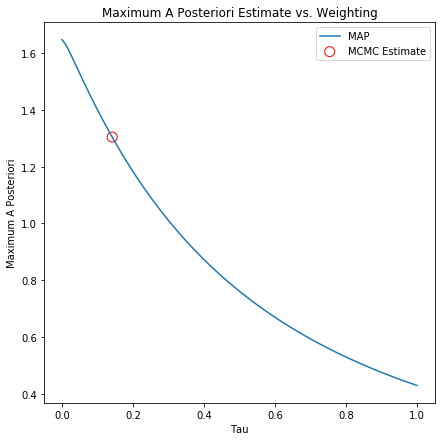

In [225]:
def cost(theta, data, tau):
    loss = -((data - theta) ** 2 + tau * theta ** 2)
    loss = -np.sum(loss)
    return loss

taus = np.linspace(0, 1, 100)
data = []
for t in taus:
    theta_0 = np.random.uniform(1, 2)
    theta = minimize(cost, theta_0, args=(data, t), method="CG")
    data.append(theta.x)
data = np.array(data)
idx = min(range(len(data)), key=lambda i: abs(data[i]-mu_posterior))
est_mu = data[idx]
est_tau = taus[idx]

# plot everything
plt.figure(figsize=(7,7))
plt.plot(taus, data)
plt.scatter(est_tau, est_mu, s=100, facecolors='none', edgecolors='r')
plt.title("Maximum A Posteriori Estimate vs. Weighting")
plt.xlabel("Tau")
plt.ylabel("Maximum A Posteriori")
plt.legend(["MAP", "MCMC Estimate"])
plt.show()

#### 2.5.4 Visualizing Everything

As we can see, our MAP estimate corresponds very closely to the mean of the posterior distribution. Similarly, when we plot the maximum likelihood estimate data, we can see that it's clustered around the MLE that we obtained using optimization.

If there's one thing to take away from this, it's that finding the MLE or MAP is often much easier than finding the density itself, since we can leverage powerful black-box optimization routines that are pretty good at finding the minima of our cost function. The downside to these methods is that we don't have access to the full distribution, which means we can't generate new examples (i.e. we don't have a generative model). This abilty to generate new examples is important in scenarios where we might want to do Monte Carlo estimation of some function that uses our fancy regression model that is fit to the data (e.g. maybe we want to approximate expected returns from a series of investments).

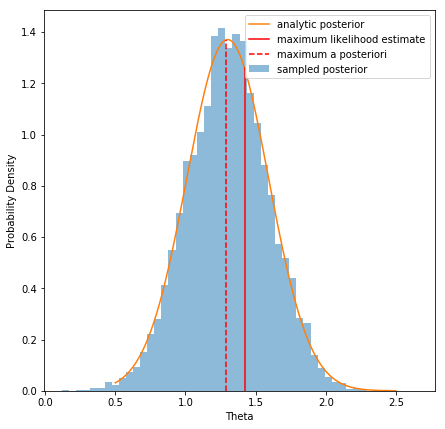

In [226]:
mle_x = mle * np.ones((100,))
mle_y = np.linspace(0, f(mle, mu_posterior, sigma_posterior), 100)

map_x = max_ap * np.ones((100,))
map_y = np.linspace(0, f(max_ap, mu_posterior, sigma_posterior), 100)

plt.figure(figsize=(7,7))
plt.hist(samples, bins=50, density=True, alpha=0.5)
plt.plot(x, y_post)
plt.plot(mle_x, mle_y, "-r")
plt.plot(map_x, map_y, "--r")
plt.xlabel("Theta")
plt.ylabel("Probability Density")
plt.legend(["analytic posterior", "maximum likelihood estimate", "maximum a posteriori", "sampled posterior"])
plt.show()

## 3. Conclusion
So I was hoping to finish off with a bit of a foray into Hamiltonian Monte Carlo, since it's the method underlying a number of modern statistical programming toolkits such as Stan and PyMC3, and it's the hammer that is used to optimize parameter weights in high dimensional problems such as Bayesian Neural Networks. However, this notebook is already covering quite a bit, and it would be impossible to give a fair treatment of HMC without also going into ODEs, the Hamiltonian, and symplectic integrators. For that reason, I'll leave it to a future post.

So what did we learn? I think the important take-aways here are that MCMC is used when we want access to a posterior distribution that is analytically intractable, or otherwise very difficult to access. The method is fully Bayesian in that it gives us the full probability density function of the posterior, rather than just a point estimate (the mean) as we would get using standard Maximum Likelihood Estimation, or the *Maximum A Priori* value. We can think of these three methods as lying on a continuum of "Bayesian-ness", with MLE not being Bayesian at all (since it uses no prior information, and only maximizes the likelihood of the parameters) to MAP, which is Bayesian in the sense that we do take prior information into consideration (regularization in the form of a prior on the parameter weights), but we still only find a point estimate that also depends on how heavily we weight the prior, and finally, MCMC, which is fully Bayesian (typically even the hyperparameters are drawn from distributions), and gives us the full posterior.

I think the final point that should be noted is that like anything, MCMC is a tool that comes with strengths and limitations. Its strength is that it's typically quite straightforward to implement (even easier if you're using a probabilistic programming library), and as seen here, it can give impressive results. if you're looking for a generative model of the posterior, MCMC is -- to my knowledge -- just about the only method that can give you that (though variational inference can give you a decent approximation). The limitations of the technique are that it struggles with the curse of dimensionality, and its overall efficiency is low compared to other algorithms (i.e. it has a burn-in phase where trials are discarded, and then it requires many samples to be drawn in order to estimate the density).